In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('/kaggle/input/drug-classification/drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [3]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [4]:
df.shape

(200, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


# One Hot Encoding

In [6]:
categoricals = []
for col in df.columns:
    if df[col].dtype == 'object':
        categoricals.append(col)

In [7]:
le = LabelEncoder()

In [8]:
for col in categoricals:
    df[col] = le.fit_transform(df[col])
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,3
2,47,1,1,0,10.114,3
3,28,0,2,0,7.798,4
4,61,0,1,0,18.043,0


# Correlation Matrix

<Axes: >

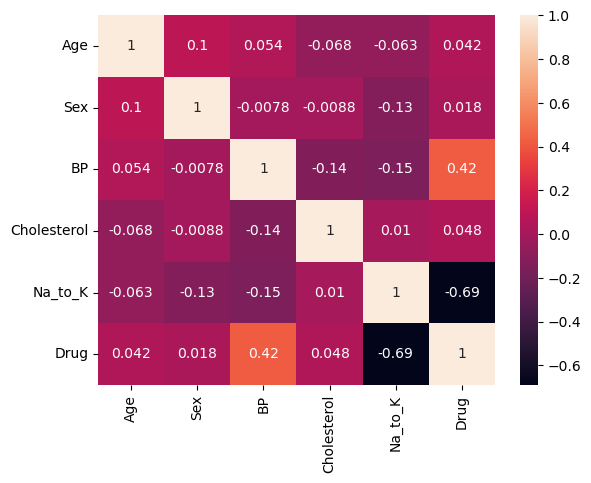

In [9]:
sns.heatmap(df.corr(),annot=True)

# Data preprocessing

In [10]:
Y = df['Drug']
X = df.drop(['Drug'],axis=1)
X.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0,0,0,25.355
1,47,1,1,0,13.093
2,47,1,1,0,10.114
3,28,0,2,0,7.798
4,61,0,1,0,18.043


In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.15,random_state=123)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=123)

# Model creation and training

In [12]:
model = xgb.XGBClassifier(booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='multi:softprob',
                       eval_metric='mlogloss',
                       max_depth=10)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=10)

[0]	validation_0-mlogloss:1.00128	validation_1-mlogloss:0.97923
[10]	validation_0-mlogloss:0.06490	validation_1-mlogloss:0.05737
[20]	validation_0-mlogloss:0.02133	validation_1-mlogloss:0.01545
[30]	validation_0-mlogloss:0.01750	validation_1-mlogloss:0.01112
[40]	validation_0-mlogloss:0.01685	validation_1-mlogloss:0.01062
[50]	validation_0-mlogloss:0.01654	validation_1-mlogloss:0.01043
[60]	validation_0-mlogloss:0.01637	validation_1-mlogloss:0.01029
[70]	validation_0-mlogloss:0.01626	validation_1-mlogloss:0.01012
[80]	validation_0-mlogloss:0.01618	validation_1-mlogloss:0.01001
[90]	validation_0-mlogloss:0.01611	validation_1-mlogloss:0.01003
[100]	validation_0-mlogloss:0.01605	validation_1-mlogloss:0.01005
[110]	validation_0-mlogloss:0.01600	validation_1-mlogloss:0.01007
[120]	validation_0-mlogloss:0.01596	validation_1-mlogloss:0.01003
[129]	validation_0-mlogloss:0.01593	validation_1-mlogloss:0.01002


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

# Model evaluation

In [13]:
yhat = model.predict(X_test)

In [14]:
print(f'{accuracy_score(yhat,y_test) * 100:.0f}%')

100%


## Confusion matrix

In [15]:
labels = le.inverse_transform(model.classes_)
labels

array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

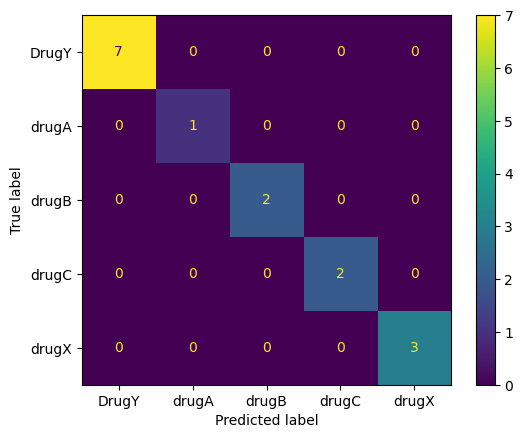

In [16]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,yhat),display_labels=labels)
cm.plot()
plt.show()

## Classification report

In [17]:
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



# Saving the model

In [18]:
model.save_model("/kaggle/working/xgb_drug_classification.bin")